## TWC-SPFP: Extracting point data for lat/lon

**Written by Campbell Watson <cwatson@us.ibm.com>** 

**Aug 06 2021**

---------------------------
This notebook extracts the TWC-SPFP forecast mean and standard deviation from PAIRS for a selected forecast and plots them

- Block 1 loads libraries and sets up PAIRS connection
- Block 2 requires user to specify forecast time, forecast length & lat/lon location
- Block 3 defines PAIRS layer numbers and dates
- Block 4 computes the **temperature adjustment** for TMAX and TAVG based on an adiabatic lapse rate scaling
- Block 5 extracts the forecast from PAIRS – mean and standard deviation
- Block 6 plots the data

In [7]:
# Load Libraries and setup PAIRS connection

from ibmpairs import paw, authentication
import json
import os
import ibmpairs
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta

# Define date format used for PAIRS
iso_8601 = "%Y-%m-%dT%H:%M:%SZ"

# PAIRS connection details ()
PAIRS_SERVER = "https://pairs.res.ibm.com/"
#os.environ['PAW_PAIRS_DEFAULT_PASSWORD_FILE_NAME'] = r'C:\Users\marani02\Documents\ibmpairspassCUT.txt'
#os.environ['PAW_PAIRS_DEFAULT_USER'] = 'ian.marang@dpi.nsw.gov.au'
#paw.load_environment_variables()
# PAIRS connection details ()
PAIRS_SERVER = "https://pairs.res.ibm.com/"
with open(r'C:\Users\marani02\OneDrive - DPIE\Documents\ibmpairspassCUT.txt', 'r') as file:
    data = file.read().replace('\n', '')
OAUTH = authentication.OAuth2(api_key=data)

print('loaded')

loaded


## USER INPUT REQUIRED
### Specify forecast time, forecast length and station name with its latitude and longitude

In [8]:
# Select variables: ["PRECIP","TMAX","TMIN","TAVG"]
Variables = ["PRECIP","TMAX","TMIN","TAVG"]

# Choose forecast initialization time
start_forecast_date = datetime.strptime("2021-05-01", "%Y-%m-%d")

# How many months of forecast to query
# **Note that the forecast duration is 7 months from 2021 and 6 months before 2021**
forecast_length_months = 7
Longitude=147.96;Latitude=-31.98
# Specify station name and lat/lon
station_name = 'Trangie'
lat, lon = -31.98,147.96

print('Obtaining data for', station_name, "at", str(lat), str(lon))

Obtaining data for Trangie at -31.98 147.96


### Define the PAIRS layer numbers and forecast dates plus horizons


In [9]:
# Designate PAIRS layers for query

# TWC-SPFP
layers_TWC = {"PRECIP": 50686, "TMIN": 50683, "TMAX": 50684, "TAVG": 50685}

# ERA5 1991-2020 Climatology
layers_ERA5 = {"PRECIP": 51198, "TMIN": 51217, "TMAX": 51200, "TAVG": 51199}

# Terrain elevation height for adiabatic lapse rate correction of TMAX and TAVG
layers_ELEVATION = {"twc_elevation": 51219, "srtm_elevation": 49506}

#---------
# Compute the list of valid_dates and horizons used to make the PAIRS query
valid_dates_horizons = []
count = 0
date = start_forecast_date
while date < start_forecast_date + relativedelta(months=forecast_length_months):
    valid_date = start_forecast_date + timedelta(days=count)
    horizon = (valid_date - start_forecast_date).days
    valid_dates_horizons.append([valid_date, horizon])
    count += 1
    date += timedelta(days=1)

print('Forecast Start Date:', valid_dates_horizons[0][0])
print('Forecast End Date:', valid_dates_horizons[-1][0])

Forecast Start Date: 2021-05-01 00:00:00
Forecast End Date: 2021-11-30 00:00:00


### Compute the temperature adjustment for TMAX and TAVG 
The adjustment is based on an adiabatic lapse rate scaling. It uses difference in surface elevation between the TWC-SPFP model and SRTM ("truth").


In [11]:
# Define dictionary to store the height for TWC and ERA5 
elevation = {}
for VARIABLE in ["twc_elevation","srtm_elevation"]:
    
    # Create json string to query PAIRS database
    query_json = {
    "layers" : [
        {"type" : "raster", "id" : layers_ELEVATION[VARIABLE]}
    ],
    "spatial" : {"type" : "point", "coordinates" : [lat, lon]},
    "temporal" : {"intervals" : [
        # used the latest elevation height available in PAIRS
        {"snapshot" : "2020-01-01T00:00:00Z"}
    ]}
    }
    
    # Define query object using PAIRSquery library
    query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH,
                           authType='api-key', overwriteExisting=True)

    # Submit query
    query.submit()

    # Extract elevation data
    elevation[VARIABLE] = query.vdf.value

# Compute lapse-rate correction for temperature 
elevation_diff = elevation['srtm_elevation'].values[0] - elevation['twc_elevation'].values[0]
temperature_adjustment = elevation_diff*(-0.0098)

print('SRTM elevation: '+str(elevation['srtm_elevation'].values[0])+' m, TWC elevation: '+str(elevation['twc_elevation'].values[0])+' m')
print('')
print('Temperature adjustment of '+str(np.round(temperature_adjustment,3))+' C to be applied to TMAX and TAVG')

`pairsHost`='https://pairs.res.ibm.com/' and `baseURI`='/' merged to: 'https://pairs.res.ibm.com/'
Unable to load point data into dataframe employing format 'text/csv': 'Querying PAIRS resulted in HTTP error code '422': .'.


Exception: Querying PAIRS resulted in HTTP error code '422': .

### Extract TWC-SPFP forecast data from PAIRS
#### Note: it only extracts the mean and standard deviation. See other sample notebooks for extracting prototypes

The extracted data is stored in two variables: 

twc_dates [Variable] <-- a list of dates

twc_values [Variable, date, mean or std-dev]  <-- a 3D array for each variable, each date, and each statistic

In [27]:
#---------
# Initialize array for storing values. Returned data will be stored in the array "values":
# values = [Variable, date, mean or std-dev]
twc_values = np.zeros((len(Variables),len(valid_dates_horizons[:]),2))

#---------
# Construct, submit and parse query

# Cycle through each variable
for var_count, variable in enumerate(Variables):
    
    print('Querying data for:', variable)

    #---------
    # Create json string to query PAIRS database
    # The query_json loops through valid_dates_horizons to create individual interval queries for each valid_date and forecast horizon
    # It also loops through two statistics – "mean" and "std" – to extract data from these two dimensions
    query_json = {
    "layers": [
        {
            "type": "raster",
            "id": layers_TWC[variable],
            "temporal": {
                "intervals": [
                    {
                        "start": (valid_date-timedelta(seconds=60)).strftime(iso_8601),
                        "end": (valid_date+timedelta(seconds=60)).strftime(iso_8601),                        
                    }
                ]
            },
            "dimensions": [
                {"name": "forecast", "value": ens},
                {"name": "horizon", "value": horizon},
            ],
        }
        for valid_date, horizon in valid_dates_horizons
        for ens in ["mean","std"]
    ],

    "spatial": {"type": "point", "coordinates": [lat, lon]},

    # This is the default time-range (to be used if a time-range isn't given in the above block/s.)
    # It is required, even though the information might not be used.
    "temporal": {"intervals": [{"snapshot": "1982-01-01"}]},
    "outputType": "json",
    }

    # Define query object using PAIRSquery library                          
    query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH,
                           authType='api-key', overwriteExisting=True)

    # Submit query
    query.submit()

    # Extract data from query return, cycling through each date
    twc_dates = []
    for ddx in range(len(query.vdf["timestamp"].values[:])):
        
        # Extract returned data from query object
        date = query.vdf["timestamp"].values[ddx]
        statistic = query.vdf["property"].values[ddx].split(";")[0].split(":")[1]
        horizon = int((query.vdf["property"].values[ddx].split(";")[1].split(":")[1]).strip('"'))
        value = float(query.vdf["value"].values[ddx])
        
        # Keep count of the unique dates in the returned query to ensure we place them in "values" correctly
        if date not in twc_dates:
            date_count = len(twc_dates)
            twc_dates.append(date)
        
        # Place returned data into correct location of "values"
        if statistic == "mean":
            
            # TMAX & TAVG: apply T-adjustment and convert from K to C
            if variable == "TMAX" or variable == "TAVG":
                twc_values[var_count,date_count,0] = value + temperature_adjustment - 273.15
            # TMIN: convert from K to C
            elif variable == "TMIN":
                twc_values[var_count,date_count,0] = value - 273.15
            # PRECIP
            elif variable == "PRECIP":
                twc_values[var_count,date_count,0] = value
            
        elif statistic == "std":
            twc_values[var_count,date_count,1] = value

    print('------------Completed Query--------------')

# Here's a quick error check in case of missing data in PAIRS
# If the length of the unique dates list does not match the length of any of the extracted values then we have a problem
if len(twc_dates) != len(twc_values[0,:,0]) or len(twc_dates) != len(twc_values[1,:,0]):
    print('WE HAVE A PROBLEM!')
    print('Length of date array and value array do not match.')
    print('Possible issue is selected forecast horizon length: max forecast horizon = 7 months from Jan 2021, otherwise 6 months.')
    

Querying data for: PRECIP


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


------------Completed Query--------------
Querying data for: TMAX


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


------------Completed Query--------------
Querying data for: TMIN


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


------------Completed Query--------------
Querying data for: TAVG


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


------------Completed Query--------------


### Plot the returned data
Remember, the structure of the data array is

twc_values = [Variable, date, mean or std-dev]

e.g., twc_values[0=Precip, :=all dates, 0=mean]


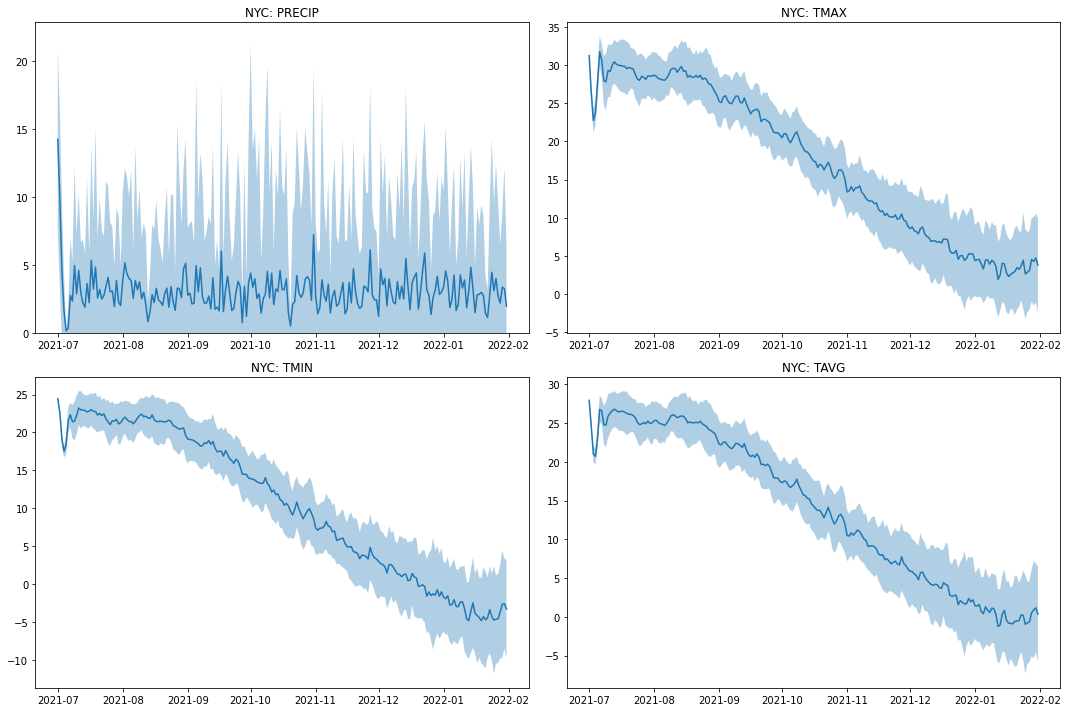

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].plot(twc_dates, twc_values[0,:,0])
ax[0,0].fill_between(twc_dates, twc_values[0,:,0]-twc_values[0,:,1], twc_values[0,:,0]+twc_values[0,:,1], alpha=0.35)
ax[0,0].set_ylim(bottom=0)
ax[0,0].set_title( station_name+': PRECIP')

ax[0,1].plot(twc_dates, twc_values[1,:,0])
ax[0,1].fill_between(twc_dates, twc_values[1,:,0]-twc_values[1,:,1], twc_values[1,:,0]+twc_values[1,:,1], alpha=0.35)
ax[0,1].set_title(station_name+': TMAX')

ax[1,0].plot(twc_dates, twc_values[2,:,0])
ax[1,0].fill_between(twc_dates, twc_values[2,:,0]-twc_values[2,:,1], twc_values[2,:,0]+twc_values[2,:,1], alpha=0.35)
ax[1,0].set_title(station_name+': TMIN')

ax[1,1].plot(twc_dates, twc_values[3,:,0])
ax[1,1].fill_between(twc_dates, twc_values[3,:,0]-twc_values[3,:,1], twc_values[3,:,0]+twc_values[3,:,1], alpha=0.35)
ax[1,1].set_title(station_name+': TAVG')

formatter = mdates.DateFormatter("%Y-%m")
ax[0,0].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


### Extract ERA5 climatology (1991-2020) from PAIRS for each variable

In [29]:
# Initialize lists for storing values
climo_dates = []
climo_values = []

# Loop through each variable in turn
for variable in Variables:
    
    print('Querying data for:', variable)
    
    # Create json string to query PAIRS database
    # Here we query the entire year of daily climatology data
    query_json = {
    "layers" : [
        {"type" : "raster", "id" : layers_ERA5[variable]}
    ],
    "spatial" : {"type" : "point", "coordinates" : [lat, lon]},
    "temporal" : {"intervals" : [
        {"start" :  "2019-12-31T23:59:00Z", "end" : "2020-12-31T00:01:00Z"}
    ]}
    }

    query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH,
                           authType='api-key', overwriteExisting=True)

    query.submit()

    #print(query.vdf)
    
    # Extract dates and values from query and convert to a list
    climo_dates_variable = list(query.vdf["timestamp"].values[:])
    climo_values_variable = list((query.vdf["value"].values[:]))

    # Create temporary lists for storing data
    dates_var = []
    values_var = []

    # We have extracted a full year of climatology data – which is year-agnostic – which we need to re-order to match the forecast dates 
    # Cycle through forecast dates and extract respective climatology values. Create a new climatology date list to match the forecast dates
    for date, horizon in valid_dates_horizons:
        
        # Append forecast date to new date list for climo
        dates_var.append(date)
        
        # Convert forecst date to np.datetime64 object to find its matching index in the PAIRS-extracted climo date list
        search_date = np.datetime64("2020-"+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)+'T00:00:00.000000000')
        
        # Find index of matching forecast date in PAIRS-extracted climo date list
        index = np.where(climo_dates_variable==search_date)[0][0]
        
        # Append climo value to the new list ordered by forecast date 
        # TMAX & TAVG: apply T-adjustment and convert from K to C
        if variable == "TMAX" or variable == "TAVG":
            values_var.append(float(climo_values_variable[index] + temperature_adjustment - 273.15))
        # TMIN: convert from K to C
        elif variable == "TMIN":
            values_var.append(float(climo_values_variable[index] - 273.15))
        # PRECIP
        elif variable == "PRECIP":
            values_var.append(float(climo_values_variable[index]))        
        
    climo_dates.append(dates_var)
    climo_values.append(values_var)

print('------------Completed Climatology Query--------------')

Querying data for: PRECIP


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


Querying data for: TMAX


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


Querying data for: TMIN


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


Querying data for: TAVG


GeoPandas not available on your system. Cannot convert vector dataframe to GeoPandas dataframe.


------------Completed Climatology Query--------------


### Plot the returned data with the climatology (red line)

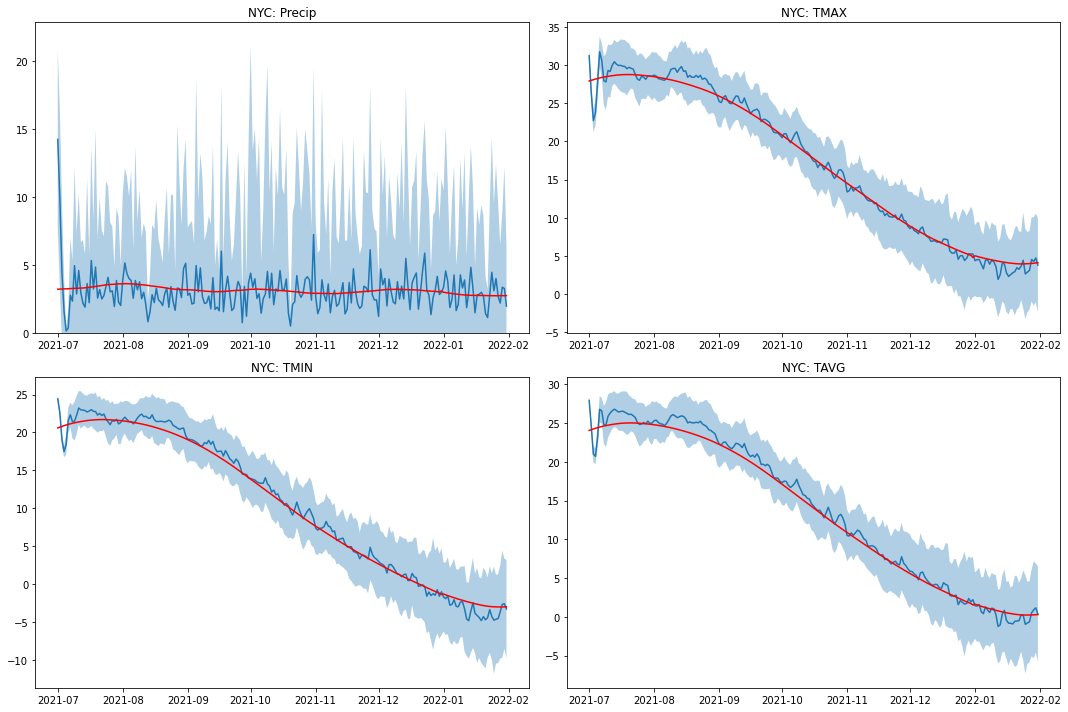

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].plot(twc_dates, twc_values[0,:,0])
ax[0,0].plot(climo_dates[0], climo_values[0], color="red")
ax[0,0].fill_between(twc_dates, twc_values[0,:,0]-twc_values[0,:,1], twc_values[0,:,0]+twc_values[0,:,1], alpha=0.35)
ax[0,0].set_ylim(bottom=0)
ax[0,0].set_title( station_name+': Precip')

ax[0,1].plot(twc_dates, twc_values[1,:,0])
ax[0,1].plot(climo_dates[1], climo_values[1], color="red")
ax[0,1].fill_between(twc_dates, twc_values[1,:,0]-twc_values[1,:,1], twc_values[1,:,0]+twc_values[1,:,1], alpha=0.35)
ax[0,1].set_title(station_name+': TMAX')

ax[1,0].plot(twc_dates, twc_values[2,:,0])
ax[1,0].plot(climo_dates[2], climo_values[2], color="red")
ax[1,0].fill_between(twc_dates, twc_values[2,:,0]-twc_values[2,:,1], twc_values[2,:,0]+twc_values[2,:,1], alpha=0.35)
ax[1,0].set_title(station_name+': TMIN')

ax[1,1].plot(twc_dates, twc_values[3,:,0])
ax[1,1].plot(climo_dates[3], climo_values[3], color="red")
ax[1,1].fill_between(twc_dates, twc_values[3,:,0]-twc_values[3,:,1], twc_values[3,:,0]+twc_values[3,:,1], alpha=0.35)
ax[1,1].set_title(station_name+': TAVG')

formatter = mdates.DateFormatter("%Y-%m")
ax[0,0].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

### Plot the returned data as an anomaly (departure from climatology)

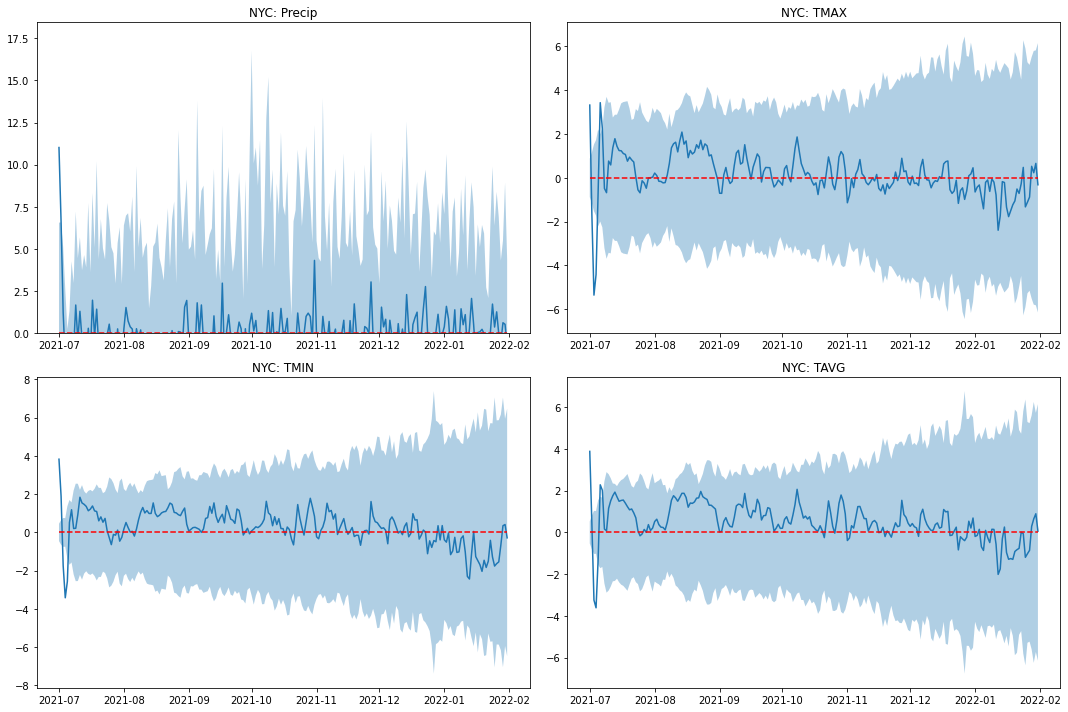

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].plot(twc_dates, twc_values[0,:,0]-climo_values[0])
ax[0,0].plot(climo_dates[0], [0]*len(climo_dates[0]), color="red", linestyle='--')
ax[0,0].fill_between(twc_dates, 0-twc_values[0,:,1], 0+twc_values[0,:,1], alpha=0.35)
ax[0,0].set_ylim(bottom=0)
ax[0,0].set_title( station_name+': Precip')

ax[0,1].plot(twc_dates, twc_values[1,:,0]-climo_values[1])
ax[0,1].plot(climo_dates[1], [0]*len(climo_dates[1]), color="red", linestyle='--')
ax[0,1].fill_between(twc_dates, 0-twc_values[1,:,1], 0+twc_values[1,:,1], alpha=0.35)
ax[0,1].set_title(station_name+': TMAX')

ax[1,0].plot(twc_dates, twc_values[2,:,0]-climo_values[2])
ax[1,0].plot(climo_dates[2], [0]*len(climo_dates[2]), color="red", linestyle='--')
ax[1,0].fill_between(twc_dates, 0-twc_values[2,:,1], 0+twc_values[2,:,1], alpha=0.35)
ax[1,0].set_title(station_name+': TMIN')

ax[1,1].plot(twc_dates, twc_values[3,:,0]-climo_values[3])
ax[1,1].plot(climo_dates[3], [0]*len(climo_dates[3]), color="red", linestyle='--')
ax[1,1].fill_between(twc_dates, 0-twc_values[3,:,1], 0+twc_values[3,:,1], alpha=0.35)
ax[1,1].set_title(station_name+': TAVG')

formatter = mdates.DateFormatter("%Y-%m")
ax[0,0].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()